<a href="https://colab.research.google.com/github/N1colasFD/Data_science_aplicada_reto_twitter/blob/main/actividad_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RUIDO EN IMAGENES EN GRISES

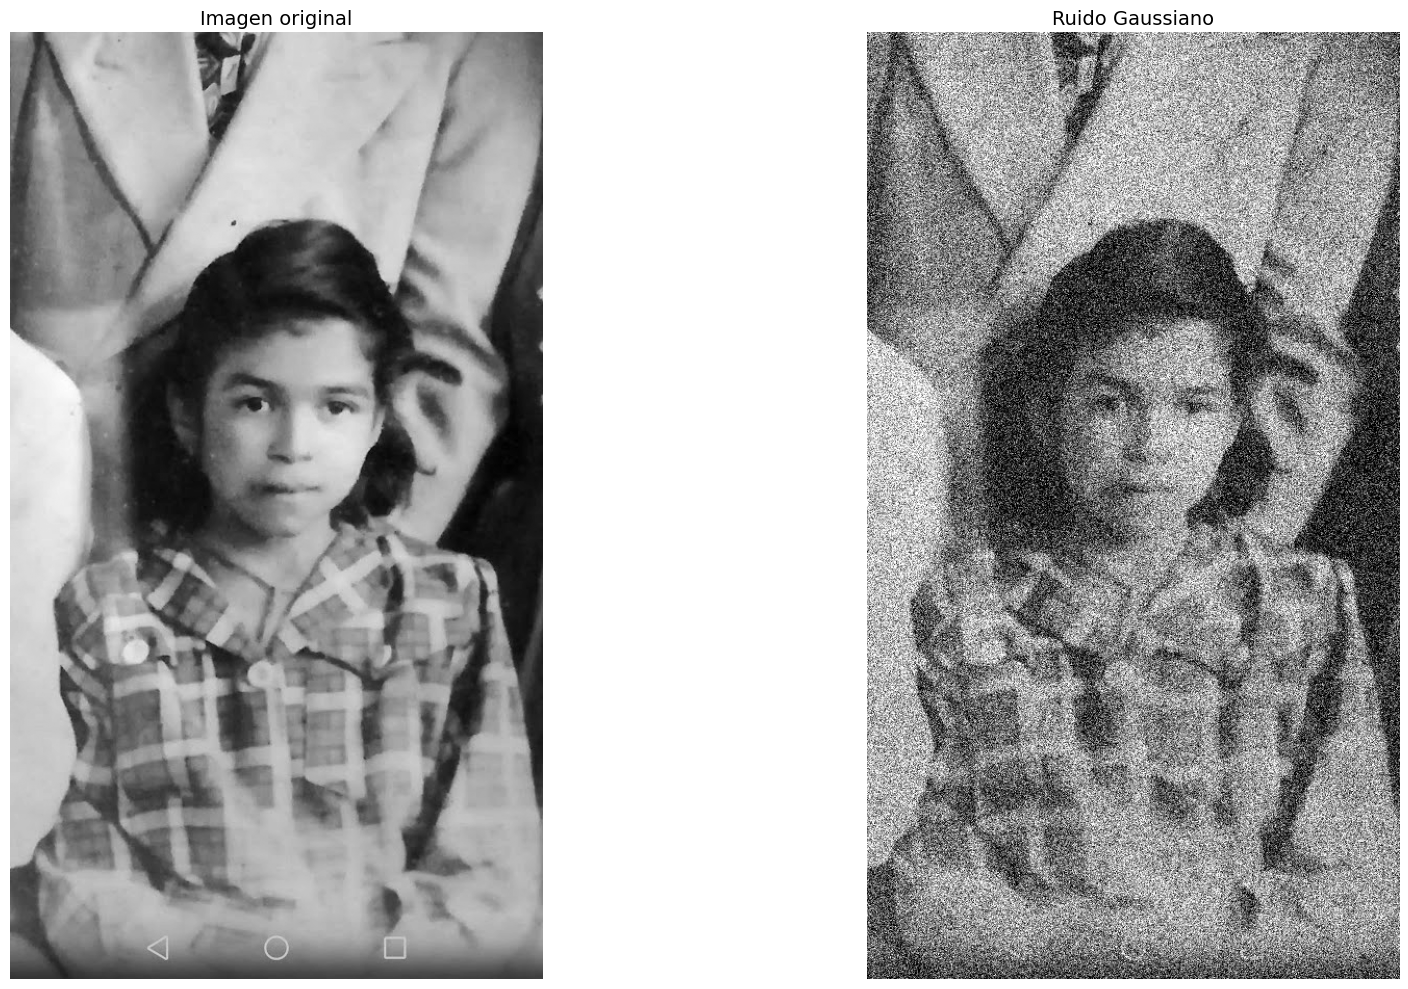

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.color import rgb2gray

# Cargar una imagen de ejemplo en escala de grises
image = img_as_float(rgb2gray(plt.imread('/content/nina.jpg')))

# Generar diferentes tipos de ruido
noisy_gaussian = random_noise(image, mode='gaussian', var=0.05)       # Ruido Gaussiano

# Mostrar imágenes
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax = axes.ravel()

titles = ['Imagen original', 'Ruido Gaussiano', 'Sal y Pimienta', 'Poisson', 'Speckle']
images = [image, noisy_gaussian]

for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

RUIDO EN IMAGENES EN COLOR

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.util import random_noise
from skimage.restoration import (
    denoise_bilateral, denoise_nl_means, denoise_tv_chambolle, denoise_wavelet
)
from skimage.filters import median
from skimage.morphology import square
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.ndimage import uniform_filter
from scipy.signal import wiener

# Utilidad para compatibilidad de skimage
def _channel_axis(img): return -1 if img.ndim == 3 else None

# ===== 1) Promedio (box/mean) – barato, difumina bordes =====
def box_mean(img, k=3):
    return uniform_filter(img, size=k)

# ===== 2) Mediana – top para sal-y-pimienta =====
def med(img, k=3):
    return median(img, footprint=square(k))

# ===== 3) Promedio recortado (alpha-trimmed mean) – tu idea, pero robusta =====
# descarta los valores más bajos/altos del vecindario antes de promediar
def alpha_trimmed_mean(img, k=5, d=2):
    from numpy.lib.stride_tricks import sliding_window_view as swv
    if img.ndim == 3:
        return np.stack([alpha_trimmed_mean(img[..., c], k, d) for c in range(img.shape[2])], axis=-1)
    pad = k // 2
    X = swv(np.pad(img, pad, mode='edge'), (k, k))         # (H,W,k,k)
    Xs = np.sort(X.reshape(X.shape[0], X.shape[1], -1), axis=-1)
    trimmed = Xs[..., d//2: -d//2] if d > 0 else Xs
    return trimmed.mean(axis=-1)

# ===== 4) Mediana solo donde hay impulsos (mejor preservación de detalle) =====
def sp_masked_median(img, k=3, low=0.02, high=0.98):
    gray = img if img.ndim == 2 else img.mean(axis=2)
    mask = (gray <= low) | (gray >= high)
    m = med(img, k)
    out = img.copy()
    out[mask] = m[mask] if img.ndim == 2 else m[mask, :]
    return out

# ===== 5) Contraharmónico – para impulsos: Q>0 quita pimienta, Q<0 quita sal =====
def contraharmonic(img, k=3, Q=1.5):
    if img.ndim == 3:
        return np.stack([contraharmonic(img[..., c], k, Q) for c in range(img.shape[2])], axis=-1)
    pad = k // 2
    Z = np.pad(img, pad, mode='edge')
    out = np.empty_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            win = Z[i:i+k, j:j+k]
            num = np.power(win, Q+1).sum()
            den = np.power(win, Q).sum() + 1e-12
            out[i, j] = num / den
    return out

# ===== 6) Bilateral – suaviza gaussiano preservando bordes =====
def bilateral(img, sigma_color=0.06, sigma_spatial=3):
    try:
        return denoise_bilateral(img, sigma_color=sigma_color, sigma_spatial=sigma_spatial,
                                 channel_axis=_channel_axis(img))
    except TypeError:  # compat viejo
        return denoise_bilateral(img, sigma_color=sigma_color, sigma_spatial=sigma_spatial,
                                 multichannel=(img.ndim == 3))

# ===== 7) Non-Local Means – muy bueno para gaussiano =====
def nlm(img, patch_size=5, patch_distance=6, h=0.8):
    sigma_est = (np.mean(np.std(img, axis=(0, 1))) if img.ndim == 3 else np.std(img)) + 1e-8
    try:
        return denoise_nl_means(img, h=h * sigma_est, fast_mode=True,
                                patch_size=patch_size, patch_distance=patch_distance,
                                channel_axis=_channel_axis(img))
    except TypeError:
        return denoise_nl_means(img, h=h * sigma_est, fast_mode=True,
                                patch_size=patch_size, patch_distance=patch_distance,
                                multichannel=(img.ndim == 3))

# ===== 8) TV-Chambolle – elimina ruido manteniendo contornos =====
def tv(img, weight=0.08):
    return denoise_tv_chambolle(img, weight=weight, channel_axis=_channel_axis(img))

# ===== 9) Wavelet – gaussiano, a veces Poisson =====
def wavelet(img):
    return denoise_wavelet(img, rescale_sigma=True, channel_axis=_channel_axis(img))

# ===== 10) Wiener local – lineal, barato =====
def wiener_local(img, k=5):
    if img.ndim == 3:
        return np.stack([wiener(img[..., c], mysize=k) for c in range(img.shape[2])], axis=-1)
    return wiener(img, mysize=k)

# ===== 11) Lee – clásico para ruido speckle (multiplicativo) =====
def lee_filter(img, k=7):
    if img.ndim == 3:
        return np.stack([lee_filter(img[..., c], k) for c in range(img.shape[2])], axis=-1)
    mean = uniform_filter(img, k)
    mean_sq = uniform_filter(img*img, k)
    var = mean_sq - mean**2
    noise_var = np.median(var)
    W = var / (var + noise_var + 1e-12)
    return mean + W * (img - mean)

# ===== Benchmark rápido (PSNR/SSIM) y visualización =====
def try_denoisers(clean, noisy, keep=None):
    methods = {
        'box_mean(5)': lambda x: box_mean(x, 5),
        'median(3)':   lambda x: med(x, 3),
        'alpha_trim(5,d=4)': lambda x: alpha_trimmed_mean(x, 5, 4),
        'sp_masked_median':  lambda x: sp_masked_median(x, 3),
        'contraharm(Q=1.5)': lambda x: contraharmonic(x, 3, 1.5),
        'bilateral':   lambda x: bilateral(x, 0.06, 3),
        'nl_means':    nlm,
        'tv':          lambda x: tv(x, 0.08),
        'wavelet':     wavelet,
        'wiener(5)':   lambda x: wiener_local(x, 5),
        'lee(7)':      lambda x: lee_filter(x, 7),
    }
    if keep: methods = {k:v for k,v in methods.items() if k in keep}
    out = {}
    for name, fn in methods.items():
        den = np.clip(fn(noisy), 0, 1)
        P = psnr(clean, den, data_range=1.0)
        S = ssim(clean, den, data_range=1.0, channel_axis=_channel_axis(den))
        out[name] = (den, P, S)
    return out

def show_results(results, cols=3):
    names = list(results.keys()); n = len(names)
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = np.atleast_2d(axes).ravel()
    for i, name in enumerate(names):
        im, P, S = results[name]
        axes[i].imshow(im, cmap='gray' if im.ndim==2 else None)
        axes[i].set_title(f'{name}\nPSNR {P:.2f} | SSIM {S:.3f}')
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()



/tmp/ipython-input-2190157116.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  return median(img, footprint=square(k))


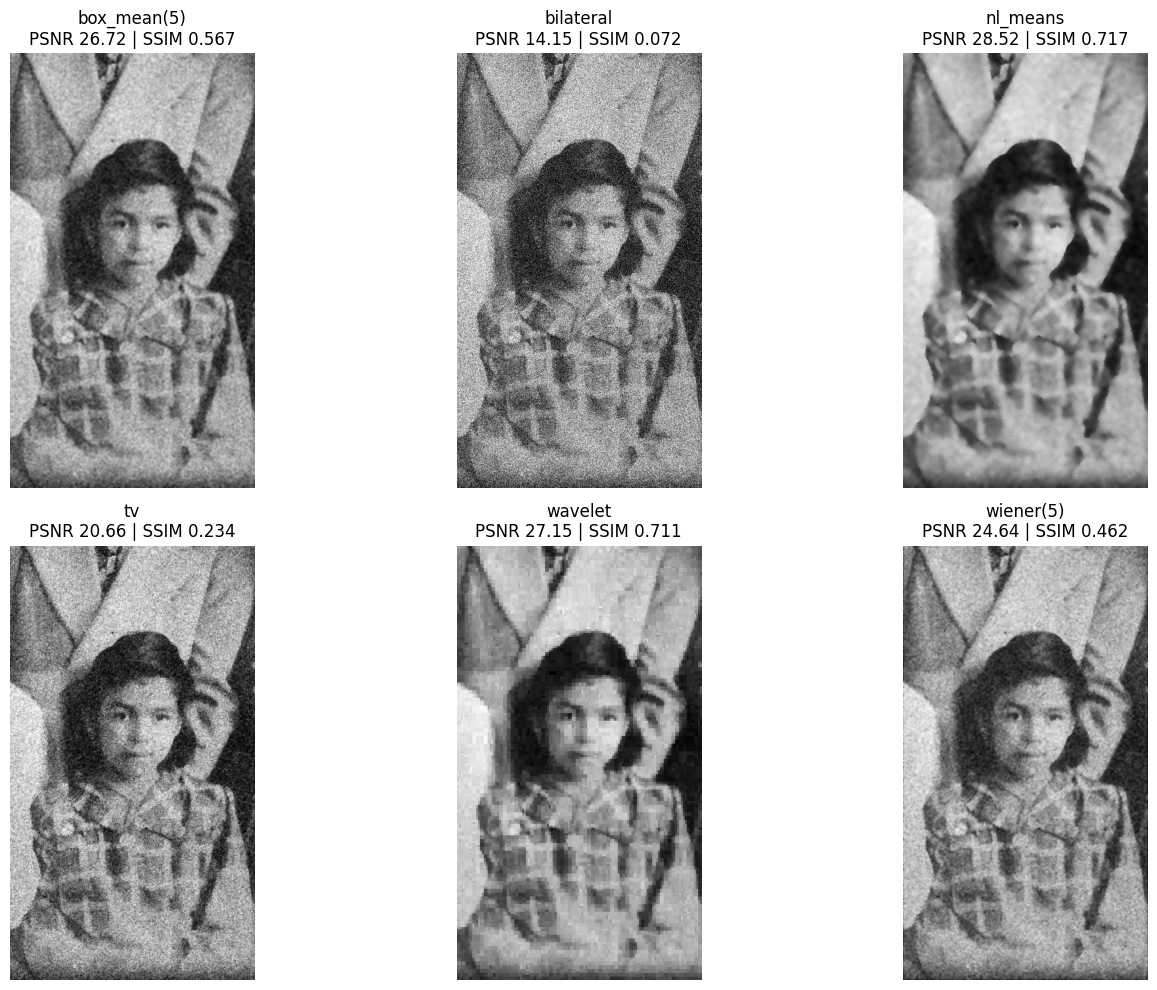

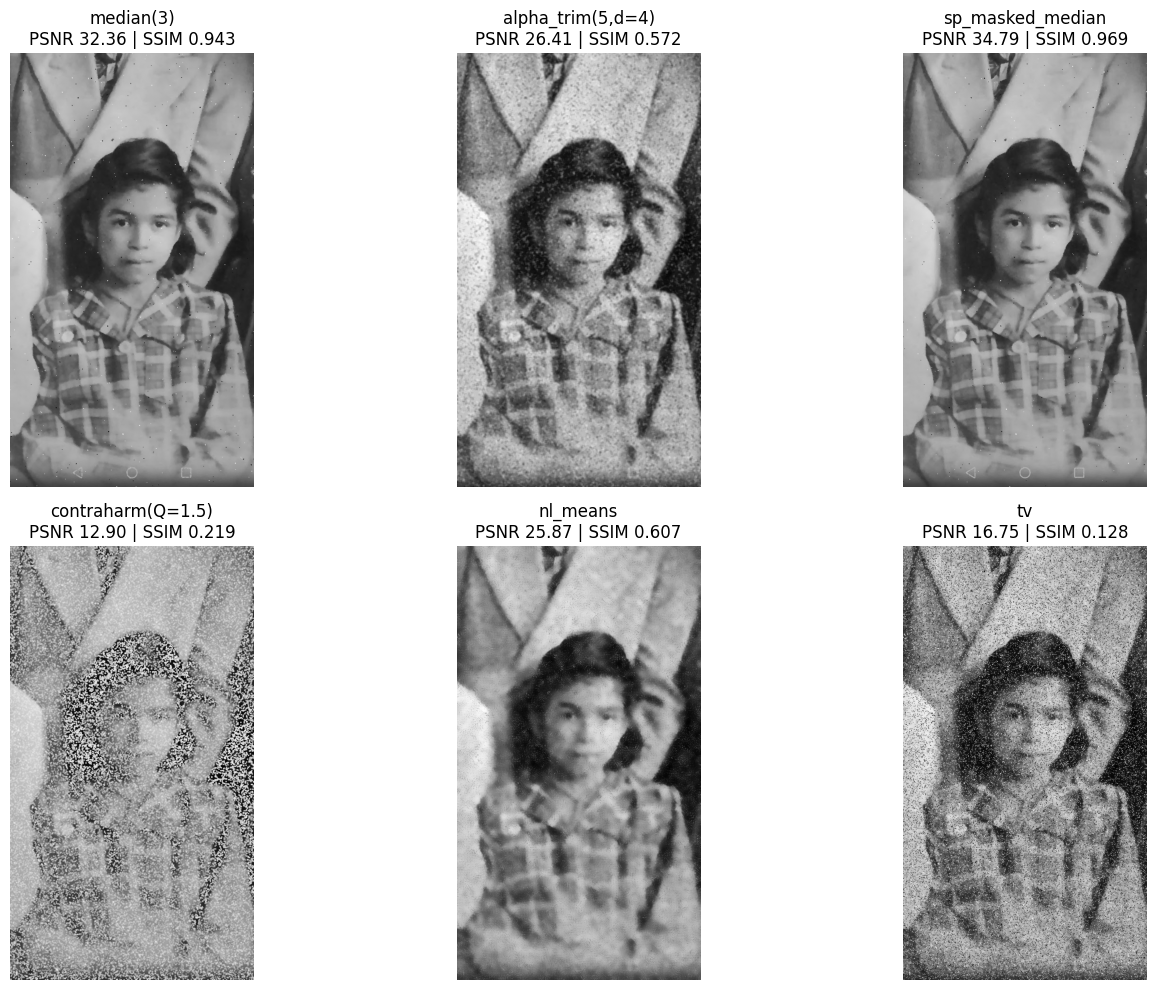

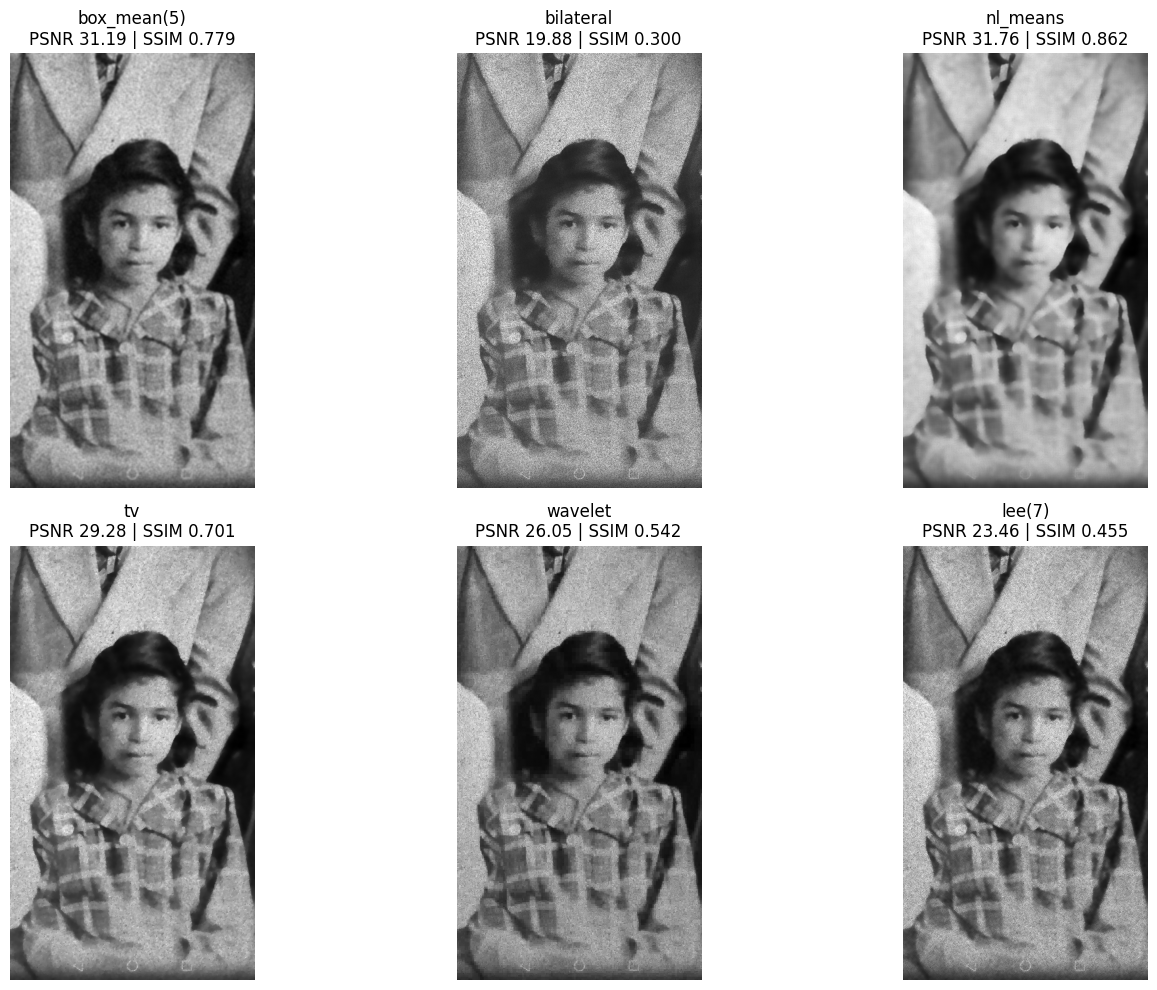

In [4]:
# Carga (gris) y genera ruido
img = img_as_float(io.imread('/content/nina.jpg', as_gray=True))

noisy_gauss = random_noise(img, mode='gaussian', var=0.05)
R_g = try_denoisers(img, noisy_gauss,
                    keep=['box_mean(5)','bilateral','nl_means','tv','wavelet','wiener(5)'])
show_results(R_g)

noisy_sp = random_noise(img, mode='s&p', amount=0.2)  # sal y pimienta
R_sp = try_denoisers(img, noisy_sp,
                     keep=['median(3)','alpha_trim(5,d=4)','sp_masked_median','contraharm(Q=1.5)','nl_means','tv'])
show_results(R_sp)

noisy_speckle = random_noise(img, mode='speckle', var=0.05)
R_spk = try_denoisers(img, noisy_speckle,
                      keep=['box_mean(5)','bilateral','nl_means','tv','wavelet','lee(7)'])
show_results(R_spk)
